In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from math import sqrt, cos, exp
from math import pi
import operator
from sklearn.preprocessing import normalize

In [4]:
data = pd.read_csv('ecoli.csv')
data.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,0
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,0
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,0
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,0
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,0


In [5]:
data.shape

(327, 8)

In [6]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [7]:
from sklearn.preprocessing import MinMaxScaler
x = pd.DataFrame(MinMaxScaler().fit_transform(x))
x.head()

,0,1,2,3,4,5,6
0,0.550562,0.154762,0.0,0.0,0.636364,0.216495,0.353535
1,0.078652,0.285714,0.0,0.0,0.613636,0.329897,0.444444
2,0.629213,0.285714,0.0,0.0,0.556818,0.350515,0.464646
3,0.662921,0.392857,0.0,0.0,0.590909,0.432990,0.363636
4,0.258427,0.190476,0.0,0.0,0.625000,0.226804,0.353535


In [8]:
x = x.drop([2, 3], axis=1)
x.head()

,0,1,4,5,6
0,0.550562,0.154762,0.636364,0.216495,0.353535
1,0.078652,0.285714,0.613636,0.329897,0.444444
2,0.629213,0.285714,0.556818,0.350515,0.464646
3,0.662921,0.392857,0.590909,0.432990,0.363636
4,0.258427,0.190476,0.625000,0.226804,0.353535


In [9]:
distFuncs = ["manhattan", "euclidean", "chebyshev"]
kernFuncs = ["uniform", "triangular", "epanechnikov", "quartic", "triweight", "tricube", "gaussian", "cosine", "logistic", "sigmoid"]
windFuncs = ["fixed", "variable"]

In [18]:
def manhattan(a, b):
    ans = 0
    for i in range(len(a)):
        ans += abs(a[i] - b[i])
    return ans

def euclidean(a, b):
    ans = 0
    for i in range (len(a)):
        ans += pow(a[i] - b[i], 2)
    return sqrt(ans)

def chebyshev(a, b):
    maxDist = -1
    for i in range (len(a)):
        maxDist = max(maxDist, abs(a[i] - b[i]))
    return maxDist

def uniform(a):
    return 0.5 if (abs(a) < 1) else 0.0

def triangular(a):
    return (1 - abs(a)) if (abs(a) < 1) else 0.0

def epanechnikov(a):
    return 3 / 4 * (1 - pow(a, 2)) if (abs(a) < 1) else 0.0

def quartic(a):
    return 15 / 16 * pow((1 - pow(a, 2)), 2) if (abs(a) < 1) else 0.0

def triweight(a):
    return 35 / 32 * pow((1 - pow(a, 2)), 3) if (abs(a) < 1) else 0.0

def tricube(a):
    return 70 / 81 * pow((1 - pow(abs(a), 3)), 3) if (abs(a) < 1) else 0.0

def gaussian(a):
    return 1 / sqrt(pi * 2) * exp((-0.5) * pow(a, 2));

def cosine(a):
    return pi / 4 * cos(pi / 2 * a) if (abs(a) < 1) else 0.0

def logistic(a):
    return 1 / (exp(a) + 2 + exp(-a))

def sigmoid(a):
    return 2 / pi * (1 / (exp(a) + exp(-a)))

def fixed(h, p, distFunc):
    pLen = len(p)
    pKern = [0] * pLen
    for i in range(pLen):
        if (h == 0):
            pKern[i] = 0
        else:
            pKern[i] = distFunc(p[i] / h)
    return pKern

def variable(k, p, distFunc):
    return fixed(p[k], p, distFunc)

def countFScore(x, y, isFixed, h, kernlFunc, distFunc):
    size = len(x)
    actualClasses = list()
    predictedClasses = list()
    for i in range(size):
        train_x = x.drop(i).values.tolist()
        train_y = y.drop(i).values.tolist()
        test_x = x.iloc[i].values.tolist()
        test_y = y.iloc[i]
        actualClasses.append(test_y)
        predictedClasses.append(predictClass(test_x, train_x, train_y, isFixed, h ,kernlFunc, distFunc))
    return f1_score(actualClasses, predictedClasses, average='micro')

def predictClass(q, p, targets, isFixed, h, kernlFunc, distFunc):
    pNum = len(p)
    p = map(lambda x: globals()[distFunc](x, q), p)
    p, targets = zip(*sorted(zip(p, targets), key=lambda x: x[0]))
    kernelArr = []
    if (isFixed):
        kernelArr = fixed(h, p, globals()[kernlFunc])
    else:
        kernelArr = variable(h, p, globals()[kernlFunc])
    mapClasses = {}
    classValues = [0, 1, 4, 5, 7]
    for key in classValues:
        mapClasses[key] = 0
    for i in range(len(kernelArr)):
        mapClasses[targets[i]] += kernelArr[i]
    return max(mapClasses.items(), key=operator.itemgetter(1))[0]


In [ ]:
ans = list()
for distFunc in distFuncs:
    for kernFunc in kernFuncs:
        for windFunc in windFuncs:
            for h in range(1, 10):
                curFScore = countFScore(x, y, windFunc == "fixed", h, kernFunc, distFunc)
                ans.append((curFScore, distFunc + " " + kernFunc + " " + windFunc + " " + str(h)))
                print(distFunc + " " + kernFunc + " " + windFunc + " " + str(h) + " FScore - " + str(curFScore))
ans.sort(key=lambda x: x[0], reverse = True)
print(ans[0][1])

manhattan uniform fixed 1 FScore - 0.7125382262996943
manhattan uniform fixed 2 FScore - 0.44036697247706424
manhattan uniform fixed 3 FScore - 0.43730886850152906
manhattan uniform fixed 4 FScore - 0.43730886850152906
manhattan uniform fixed 5 FScore - 0.43730886850152906
manhattan uniform fixed 6 FScore - 0.43730886850152906
manhattan uniform fixed 7 FScore - 0.43730886850152906
manhattan uniform fixed 8 FScore - 0.43730886850152906
manhattan uniform fixed 9 FScore - 0.43730886850152906
manhattan uniform variable 1 FScore - 0.81651376146789
manhattan uniform variable 2 FScore - 0.8348623853211009
manhattan uniform variable 3 FScore - 0.8532110091743119
manhattan uniform variable 4 FScore - 0.8623853211009176
manhattan uniform variable 5 FScore - 0.8654434250764526
manhattan uniform variable 6 FScore - 0.8623853211009176
manhattan uniform variable 7 FScore - 0.8685015290519877
manhattan uniform variable 8 FScore - 0.8746177370030581
manhattan uniform variable 9 FScore - 0.874617737003

In [ ]:
ans.sort(key=lambda x: x[0], reverse = True)
print(ans[0][1])
print(ans[0][0])

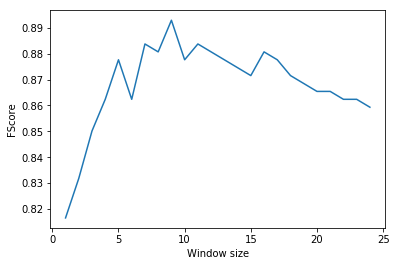

In [12]:
FScores = list()
for h in range(1, 25):
    FScore = countFScore(x, y, False, h, "uniform", "euclidean")
    FScores.append(FScore)
plt.plot(range(1, 25), FScores)
plt.xlabel('Window size')
plt.ylabel('FScore')
plt.show()

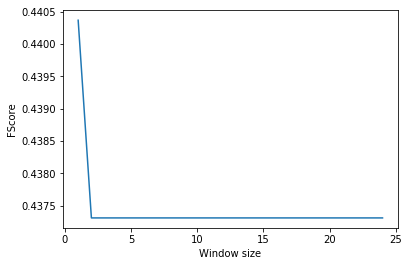

In [13]:
FScores = list()
for h in range(1, 25):
    FScore = countFScore(x, y, True, h, "uniform", "euclidean")
    FScores.append(FScore)
plt.plot(range(1, 25), FScores)
plt.xlabel('Window size')
plt.ylabel('FScore')
plt.show()